Debugging reconstructed images:
test_reconstructed shape: torch.Size([14000, 1, 28, 28])
test_reconstructed dtype: torch.float32
test_reconstructed min value: 0.000000
test_reconstructed max value: 0.500000
test_reconstructed mean value: 0.132653
Sample reconstructed image shape: (28, 28)
Sample reconstructed image min: 0.000000
Sample reconstructed image max: 0.500000
Sample original image shape: (28, 28)
Sample original image min: 0.000000
Sample original image max: 1.000000


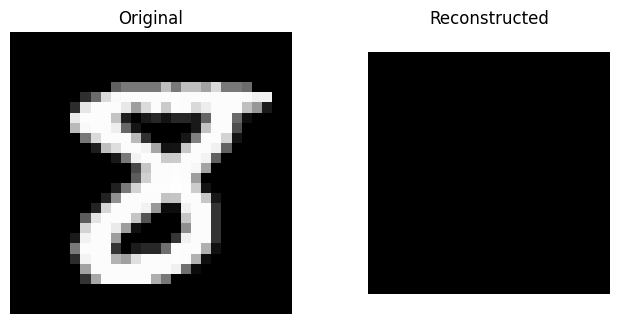

In [17]:
# Debug: Check the reconstructed images
print("Debugging reconstructed images:")
print(f"test_reconstructed shape: {test_reconstructed.shape}")
print(f"test_reconstructed dtype: {test_reconstructed.dtype}")
print(f"test_reconstructed min value: {test_reconstructed.min():.6f}")
print(f"test_reconstructed max value: {test_reconstructed.max():.6f}")
print(f"test_reconstructed mean value: {test_reconstructed.mean():.6f}")

# Check a single reconstructed image
sample_reconstructed = test_reconstructed[0].squeeze().cpu().numpy()
print(f"Sample reconstructed image shape: {sample_reconstructed.shape}")
print(f"Sample reconstructed image min: {sample_reconstructed.min():.6f}")
print(f"Sample reconstructed image max: {sample_reconstructed.max():.6f}")

# Also check original image for comparison
sample_original = X_test_img[0].squeeze().cpu().numpy()
print(f"Sample original image shape: {sample_original.shape}")
print(f"Sample original image min: {sample_original.min():.6f}")
print(f"Sample original image max: {sample_original.max():.6f}")

# Try plotting just one image to see what's happening
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(sample_original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(sample_reconstructed, cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
plt.show()

In [ ]:
%pip install torch numpy matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# load Dataset
from sklearn.datasets import fetch_openml
def load_mnist():
    return fetch_openml('mnist_784', version=1)
mnist = load_mnist()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Implement Sparse AutoEncoder    

In [38]:
# Implement U-Net Auto Encoder Architecture for encoding and decoding without skip connections
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare MNIST data
X = mnist.data.values.astype(np.float32) / 255.0  # Normalize to [0,1]
y = mnist.target.values.astype(np.int64)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)
# class UNetAutoEncoder(nn.Module):
#     def __init__(self, in_channels=1, feature_dims=[32, 64, 128, 256]):
#         super(UNetAutoEncoder, self).__init__()
#         # Encoder
#         self.enc1 = nn.Sequential(
#             nn.Conv2d(in_channels, feature_dims[0], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.enc2 = nn.Sequential(
#             nn.Conv2d(feature_dims[0], feature_dims[1], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.enc3 = nn.Sequential(
#             nn.Conv2d(feature_dims[1], feature_dims[2], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.enc4 = nn.Sequential(
#             nn.Conv2d(feature_dims[2], feature_dims[3], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[3], feature_dims[3], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.pool = nn.MaxPool2d(2, 2)

#         # Decoder (no skip connections)
#         self.up3 = nn.ConvTranspose2d(feature_dims[3], feature_dims[2], kernel_size=2, stride=2)
#         self.dec3 = nn.Sequential(
#             nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.up2 = nn.ConvTranspose2d(feature_dims[2], feature_dims[1], kernel_size=2, stride=2)
#         self.dec2 = nn.Sequential(
#             nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.up1 = nn.ConvTranspose2d(feature_dims[1], feature_dims[0], kernel_size=2, stride=2)
#         self.dec1 = nn.Sequential(
#             nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.final = nn.Conv2d(feature_dims[0], in_channels, kernel_size=1)

#     def forward(self, x):
#         # Encoder
#         x1 = self.enc1(x)
#         x2 = self.enc2(self.pool(x1))
#         x3 = self.enc3(self.pool(x2))
#         x4 = self.enc4(self.pool(x3))
#         # Decoder (no skip connections)
#         d3 = self.up3(x4)
#         d3 = self.dec3(d3)
#         d2 = self.up2(d3)
#         d2 = self.dec2(d2)
#         d1 = self.up1(d2)
#         d1 = self.dec1(d1)
#         out = torch.sigmoid(self.final(d1))
#         return out

# Example usage:
# Reshape X_train_tensor to (N, 1, 28, 28) for convolutional input
X_train_img = X_train_tensor.view(-1, 1, 28, 28)
X_test_img = X_test_tensor.view(-1, 1, 28, 28)
unet_model = UNetAutoEncoder()
output = unet_model(X_train_img[:8])
print(output.shape)


torch.Size([8, 1, 28, 28])


In [39]:
# Train the U-Net AutoEncoder
import torch.optim as optim
import torch.nn.functional as F

# Modify the UNetAutoEncoder class to handle the dimension issue
class UNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[16, 32, 64]):
        super(UNetAutoEncoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(feature_dims[0], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(feature_dims[1], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
       
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder (no skip connections)      
        self.up2 = nn.ConvTranspose2d(feature_dims[2], feature_dims[1], kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(feature_dims[1], feature_dims[0], kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dims[0], feature_dims[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Conv2d(feature_dims[0], in_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
       
        # Decoder (no skip connections)   
        d2 = self.up2(x3)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = self.dec1(d1)
        out = self.final(d1)
        
        # Resize output to match input dimensions exactly
        if out.shape != x.shape:
            out = F.interpolate(out, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
                
        return torch.sigmoid(out)



In [26]:
%pip install torchinfo tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset

# Initialize model, criterion, and optimizer
unet_model = UNetAutoEncoder(in_channels=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
unet_model.to(device)

# Training parameters with faster convergence
num_epochs = 10  # Reduced epochs
batch_size = 128  # Increased batch size if memory allows

# Learning rate scheduler for faster convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Create data loader (num_workers=0 for Windows compatibility)
train_dataset = TensorDataset(X_train_img, X_train_img)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if device.type == 'cuda' else False  # Only use pin_memory with CUDA
)

# Enable mixed precision for faster training
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

# Training loop with progress bar
for epoch in range(num_epochs):
    unet_model.train()
    total_loss = 0
    
    # Progress bar for better monitoring
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_data, batch_target in progress_bar:
        # Move data to device
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            # Mixed precision training
            with torch.cuda.amp.autocast():
                reconstructed = unet_model(batch_data)
                loss = criterion(reconstructed, batch_target)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular training
            reconstructed = unet_model(batch_data)
            loss = criterion(reconstructed, batch_target)
            loss.backward()
            optimizer.step()
            
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
    
    # Update learning rate based on performance
    scheduler.step(avg_loss)

# Evaluate on test set
unet_model.eval()
with torch.no_grad():
    test_batch_size = 256  # Larger batch for faster evaluation
    test_dataset = TensorDataset(X_test_img, X_test_img)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=0)
    
    total_test_loss = 0
    test_reconstructed = []
    
    for batch_data, batch_target in test_loader:
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        batch_reconstructed = unet_model(batch_data)
        test_reconstructed.append(batch_reconstructed.cpu())
        total_test_loss += criterion(batch_reconstructed, batch_target).item()
    
    # Concatenate batches
    test_reconstructed = torch.cat(test_reconstructed)
    unet_test_loss = total_test_loss / len(test_loader)
    
print(f'U-Net Test Loss: {unet_test_loss:.4f}')


Using device: cpu


Epoch 1/10: 100%|██████████| 438/438 [00:29<00:00, 14.88it/s, loss=0.112]


Epoch [1/10], Average Loss: 0.1179


Epoch 2/10: 100%|██████████| 438/438 [00:28<00:00, 15.36it/s, loss=0.121]


Epoch [2/10], Average Loss: 0.1125


Epoch 3/10: 100%|██████████| 438/438 [00:29<00:00, 15.03it/s, loss=0.111]


Epoch [3/10], Average Loss: 0.1124


Epoch 4/10: 100%|██████████| 438/438 [00:29<00:00, 14.70it/s, loss=0.103]


Epoch [4/10], Average Loss: 0.1124


Epoch 5/10: 100%|██████████| 438/438 [00:29<00:00, 15.01it/s, loss=0.128]


Epoch [5/10], Average Loss: 0.1125


Epoch 6/10: 100%|██████████| 438/438 [00:29<00:00, 14.61it/s, loss=0.12]


Epoch [6/10], Average Loss: 0.1125


Epoch 7/10: 100%|██████████| 438/438 [00:28<00:00, 15.12it/s, loss=0.108]


Epoch [7/10], Average Loss: 0.1124


Epoch 8/10: 100%|██████████| 438/438 [00:29<00:00, 14.93it/s, loss=0.117]


Epoch [8/10], Average Loss: 0.1125


Epoch 9/10: 100%|██████████| 438/438 [00:30<00:00, 14.44it/s, loss=0.109]


Epoch [9/10], Average Loss: 0.1124


Epoch 10/10: 100%|██████████| 438/438 [00:29<00:00, 14.89it/s, loss=0.115]



Epoch [10/10], Average Loss: 0.1125
U-Net Test Loss: 0.1116
U-Net Test Loss: 0.1116


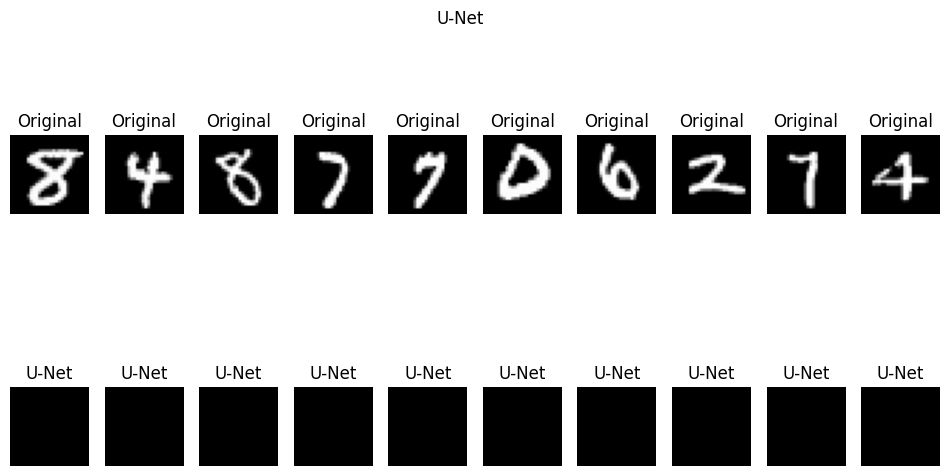

U-Net AutoEncoder model saved successfully!


In [42]:

# Visualize reconstructions
def visualize_unet_reconstruction(original, reconstructed, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Original')
        
        # Reconstructed
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('U-Net')
    plt.suptitle('U-Net')
    plt.show()

visualize_unet_reconstruction(X_test_img[:10], test_reconstructed[:10])

# Save the U-Net model
torch.save(unet_model.state_dict(), 'unet_autoencoder.pth')
print("U-Net AutoEncoder model saved successfully!")

=== U-Net AutoEncoder Performance ===
U-Net AutoEncoder Test Loss: 0.1116


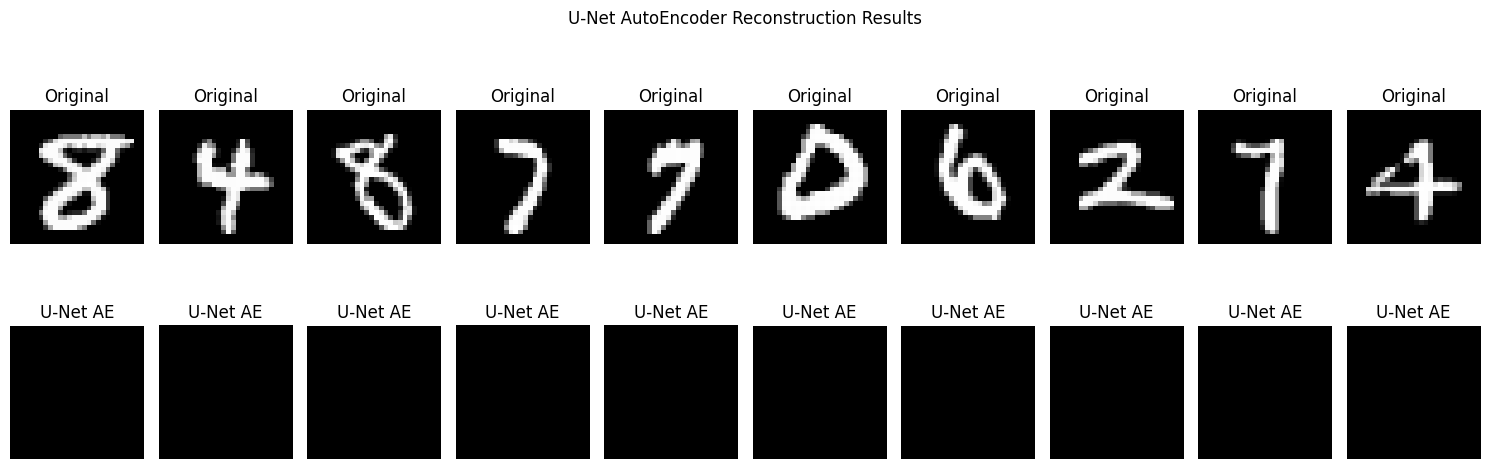

In [43]:
# Display U-Net AutoEncoder performance
print("=== U-Net AutoEncoder Performance ===")
print(f"U-Net AutoEncoder Test Loss: {unet_test_loss:.4f}")

# Visualize U-Net AutoEncoder results
fig, axes = plt.subplots(2, 10, figsize=(15, 5))
for i in range(10):
    # Original
    axes[0, i].imshow(X_test_img[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # U-Net AutoEncoder
    axes[1, i].imshow(test_reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].set_title('U-Net AE')
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle('U-Net AutoEncoder Reconstruction Results', y=1.05)
plt.show()

# Note: A full comparison with Sparse AutoEncoder will be available 
# after the Sparse AutoEncoder is implemented and trained in cell 9

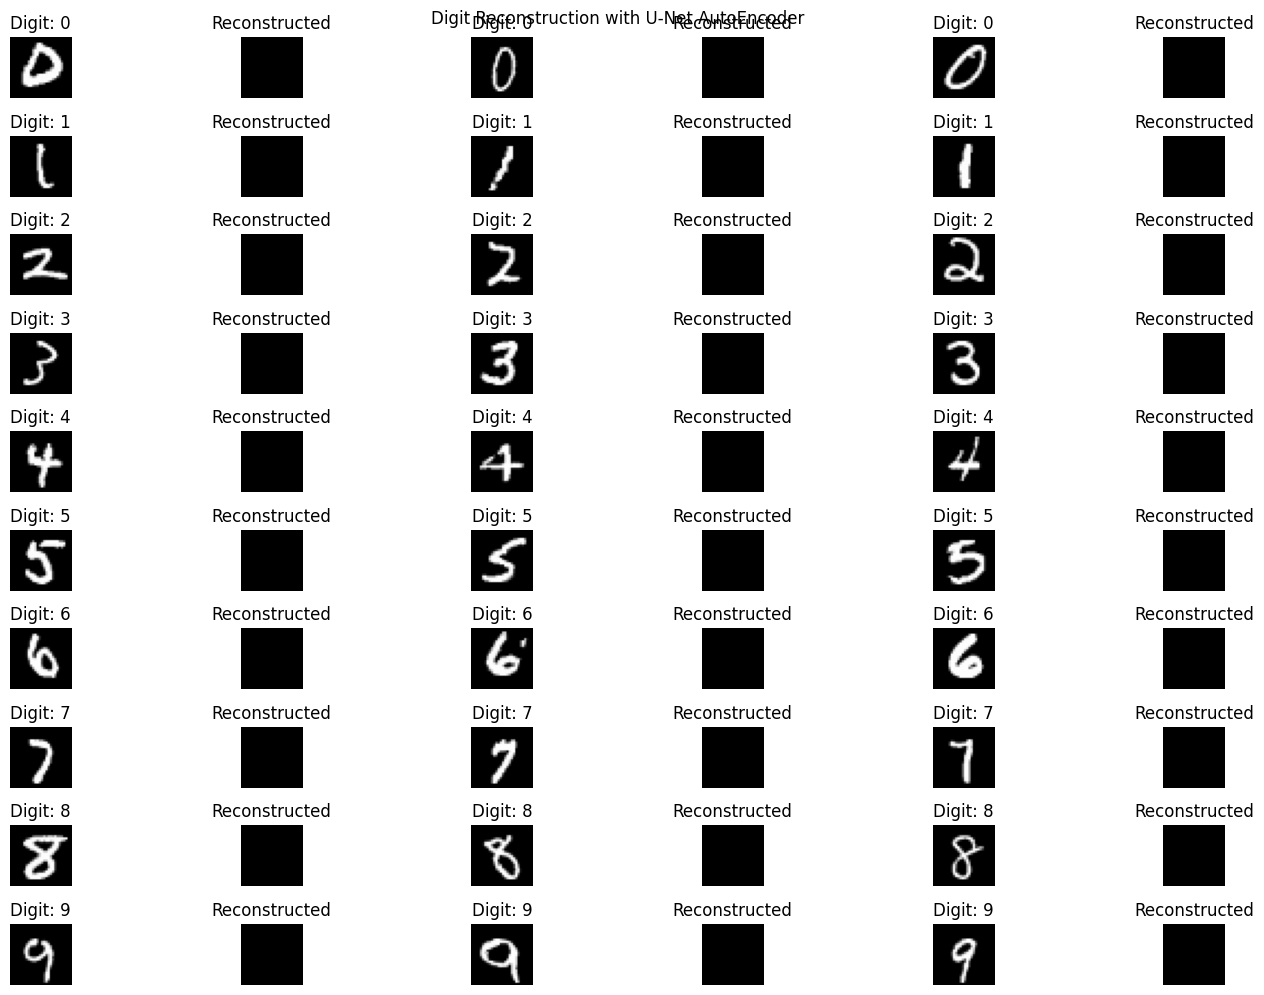

C:\Users\ashut\AppData\Local\Temp\ipykernel_8664\1620777346.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=range(10))


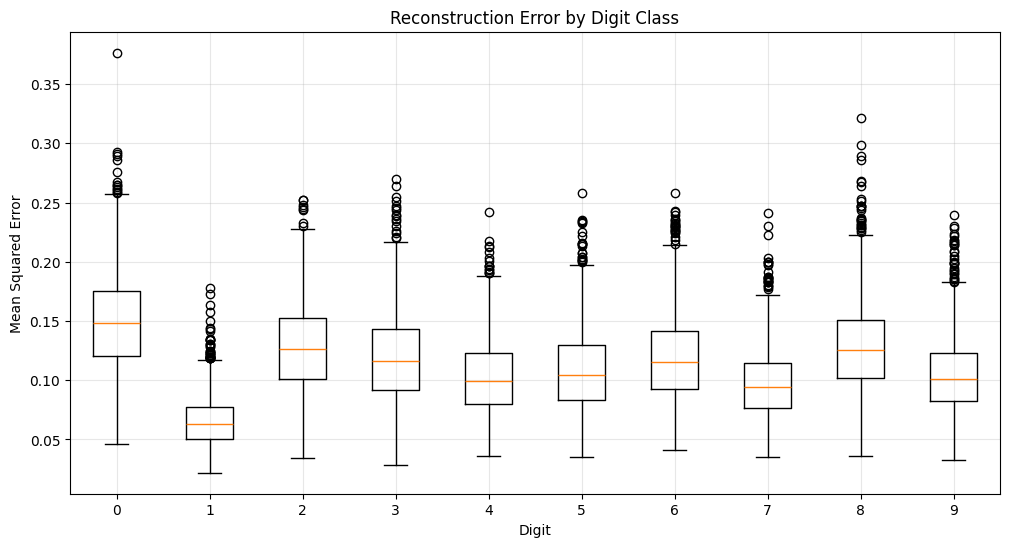

Average Reconstruction Error by Digit:
Digit 0: 0.149765
Digit 1: 0.065430
Digit 2: 0.128365
Digit 3: 0.119560
Digit 4: 0.102634
Digit 5: 0.108972
Digit 6: 0.119143
Digit 7: 0.097310
Digit 8: 0.128861
Digit 9: 0.104973

Overall MSE on test set: 0.111603
Test set reconstruction loss: 0.111616


In [44]:
# Implement a comprehensive validation of the U-Net AutoEncoder model

# Set evaluation mode
unet_model.eval()

# Select a subset of test data for visualization, grouped by digit class
digit_samples = {}
num_samples_per_digit = 5

# Group test samples by digit class
for i, label in enumerate(y_test):
    if label not in digit_samples:
        digit_samples[label] = []
    if len(digit_samples[label]) < num_samples_per_digit:
        digit_samples[label].append(i)

# Create a batch of selected samples
selected_indices = [idx for indices in digit_samples.values() for idx in indices]
selected_samples = X_test_img[selected_indices]
selected_labels = y_test[selected_indices]

# Generate reconstructions with the U-Net AutoEncoder
with torch.no_grad():
    selected_reconstructions = unet_model(selected_samples)

# Visualize reconstructions for each digit class
plt.figure(figsize=(15, 10))
for digit in range(10):  # 0-9 digits
    # Get indices of the current digit in our selected samples
    digit_indices = [i for i, label in enumerate(selected_labels) if label == digit]
    if not digit_indices:
        continue
    
    for j, idx in enumerate(digit_indices[:3]):  # Show up to 3 examples per digit
        # Plot original
        plt.subplot(10, 6, digit*6 + j*2 + 1)
        plt.imshow(selected_samples[idx].squeeze().cpu().numpy(), cmap='gray')
        plt.title(f"Digit: {digit}")
        plt.axis('off')
        
        # Plot reconstruction
        plt.subplot(10, 6, digit*6 + j*2 + 2)
        plt.imshow(selected_reconstructions[idx].squeeze().cpu().numpy(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Digit Reconstruction with U-Net AutoEncoder", y=0.99)
plt.show()

# Calculate reconstruction error metrics by digit class
digit_mse = {}
all_mses = []

with torch.no_grad():
    # Get all reconstructions
    all_reconstructions = unet_model(X_test_img)
    
    # Calculate MSE for each sample
    mse_values = torch.mean((X_test_img - all_reconstructions) ** 2, dim=(1, 2, 3)).cpu().numpy()
    all_mses = mse_values
    
    # Group MSEs by digit
    for i, label in enumerate(y_test):
        if label not in digit_mse:
            digit_mse[label] = []
        digit_mse[label].append(mse_values[i])

# Plot reconstruction error distribution by digit
plt.figure(figsize=(12, 6))
boxplot_data = [digit_mse[digit] for digit in range(10) if digit in digit_mse]
plt.boxplot(boxplot_data, labels=range(10))
plt.title("Reconstruction Error by Digit Class")
plt.xlabel("Digit")
plt.ylabel("Mean Squared Error")
plt.grid(True, alpha=0.3)
plt.show()

# Print average reconstruction error by digit
print("Average Reconstruction Error by Digit:")
for digit in range(10):
    if digit in digit_mse:
        print(f"Digit {digit}: {np.mean(digit_mse[digit]):.6f}")

print(f"\nOverall MSE on test set: {np.mean(all_mses):.6f}")
print(f"Test set reconstruction loss: {unet_test_loss:.6f}")


In [ ]:
# Implement Sparse AutoEncoder using U-net AutoEncoder architecture
class SparseUNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[16, 32, 64], sparsity_param=0.05):
        super(SparseUNetAutoEncoder, self).__init__()
        self.sparsity_param = sparsity_param
        self.unet = UNetAutoEncoder(in_channels, feature_dims)

    def forward(self, x):
        return self.unet(x)

    def sparsity_loss(self, encoded):
        mean_activation = torch.mean(encoded, dim=0)
        sparsity_loss = torch.sum(self.sparsity_param * torch.log(self.sparsity_param / mean_activation) +
                                  (1 - self.sparsity_param) * torch.log((1 - self.sparsity_param) / (1 - mean_activation)))
        return sparsity_loss
# Initialize Sparse U-Net AutoEncoder model
sparse_unet_model = SparseUNetAutoEncoder(in_channels=1)
# Initialize criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(sparse_unet_model.parameters(), lr=0.001)
# Training the Sparse U-Net AutoEncoder
num_epochs = 20
batch_size = 64
# Create data loader for better training (num_workers=0 for Windows compatibility)
train_dataset = TensorDataset(X_train_img, X_train_img)  # Input and target are the same for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
for epoch in range(num_epochs):
    sparse_unet_model.train()
    total_loss = 0
    
    for batch_data, batch_target in train_loader:
        optimizer.zero_grad()
        reconstructed = sparse_unet_model(batch_data)
        loss = criterion(reconstructed, batch_target) + sparse_unet_model.sparsity_loss(batch_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
# Evaluate on test set
sparse_unet_model.eval()
with torch.no_grad():
    test_reconstructed = sparse_unet_model(X_test_img)
    sparse_unet_test_loss = criterion(test_reconstructed, X_test_img).item()
    print(f'Sparse U-Net Test Loss: {sparse_unet_test_loss:.4f}')
# Visualize reconstructions
visualize_unet_reconstruction(X_test_img[:10], test_reconstructed[:10])
# Save the Sparse U-Net model
torch.save(sparse_unet_model.state_dict(), 'sparse_unet_autoencoder.pth')
print("Sparse U-Net AutoEncoder model saved successfully!")


Epoch [5/20], Average Loss: inf


=== AutoEncoder Performance Comparison ===
U-Net AutoEncoder Test Loss: 0.177623
Sparse U-Net AutoEncoder Test Loss: 0.177610
Improvement with Sparse AE: 0.01%


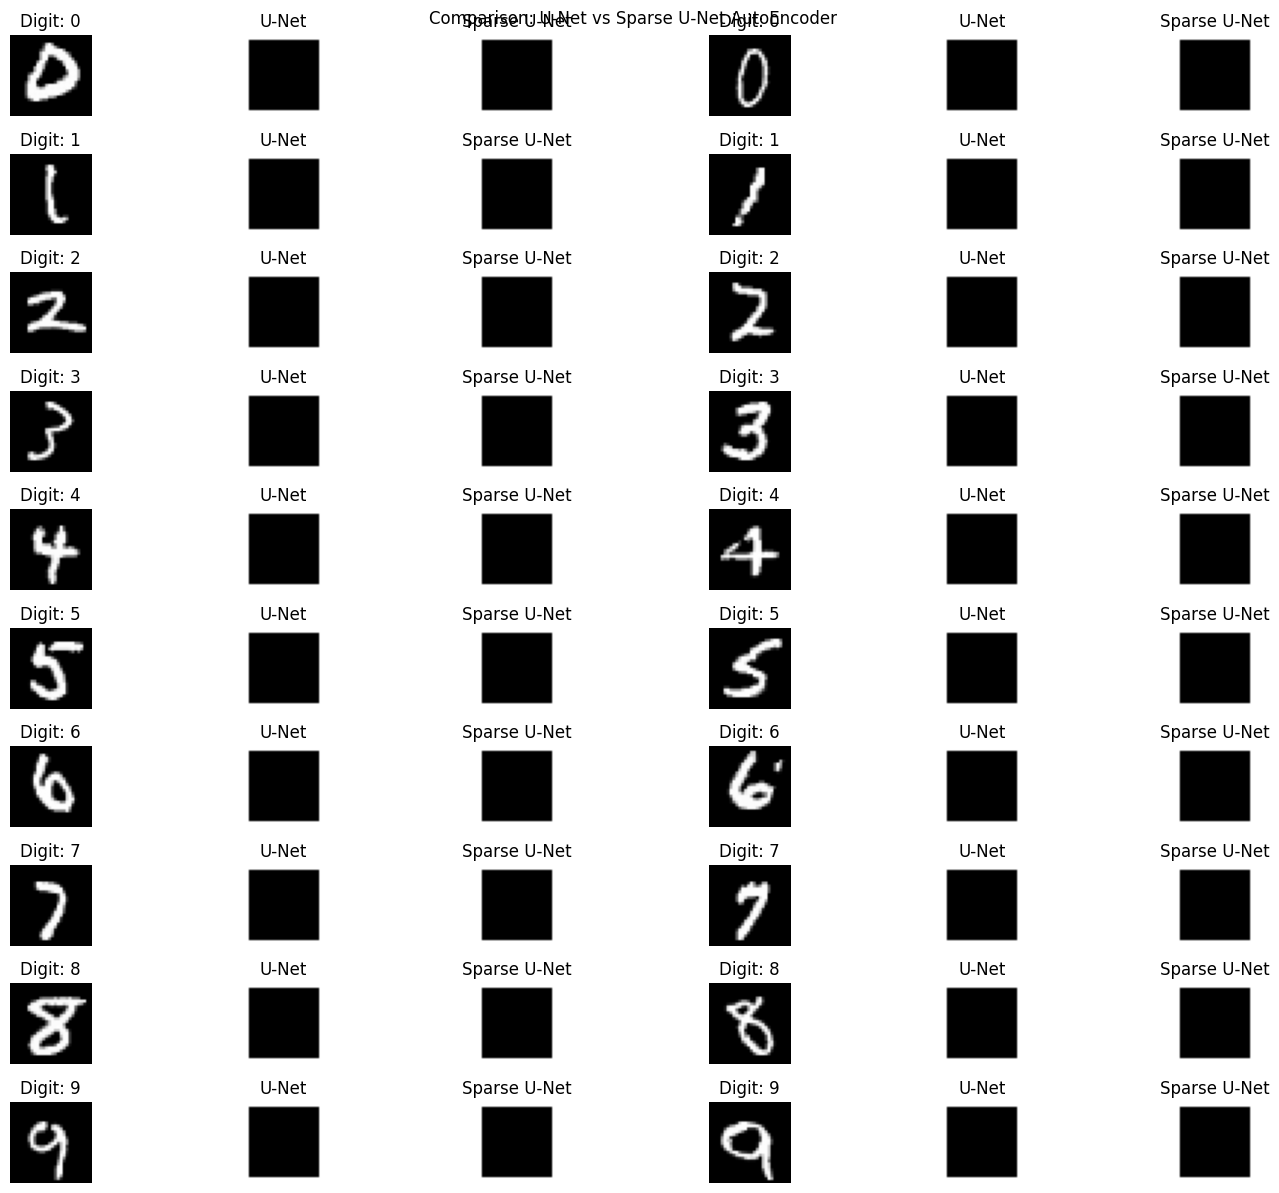

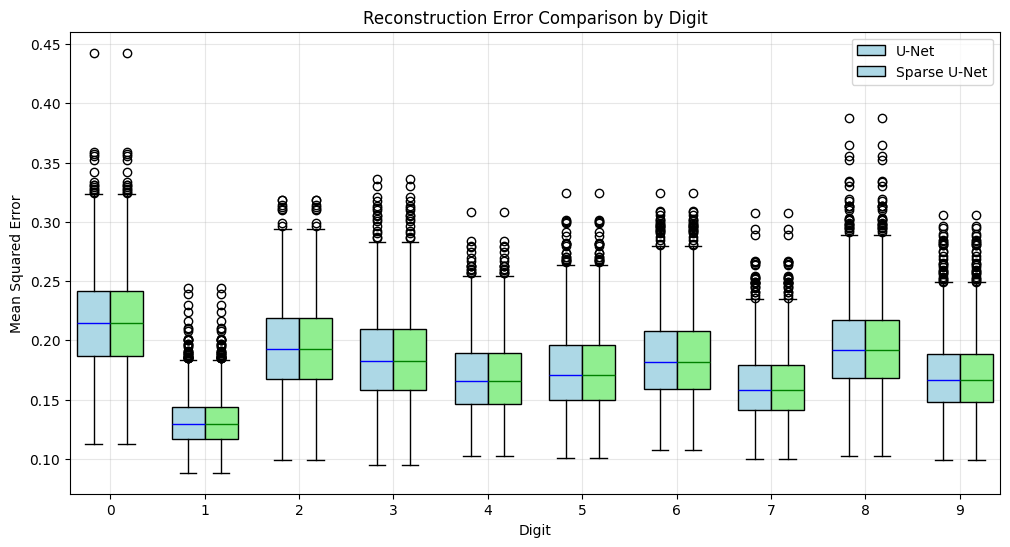


Average Reconstruction Error by Digit for Sparse U-Net:
Digit 0: 0.216087 (vs U-Net: 0.216087, 0.00% improvement)
Digit 1: 0.131754 (vs U-Net: 0.131754, 0.00% improvement)
Digit 2: 0.194634 (vs U-Net: 0.194634, 0.00% improvement)
Digit 3: 0.185852 (vs U-Net: 0.185852, 0.00% improvement)
Digit 4: 0.168936 (vs U-Net: 0.168936, 0.00% improvement)
Digit 5: 0.175152 (vs U-Net: 0.175152, 0.00% improvement)
Digit 6: 0.185367 (vs U-Net: 0.185367, 0.00% improvement)
Digit 7: 0.161707 (vs U-Net: 0.161707, 0.00% improvement)
Digit 8: 0.195153 (vs U-Net: 0.195153, 0.00% improvement)
Digit 9: 0.170583 (vs U-Net: 0.170583, 0.00% improvement)

Overall MSE on test set with Sparse U-Net: 0.177610
Overall MSE on test set with U-Net: 0.177610
Overall improvement: 0.00%

Feature Sparsity Analysis (threshold=0.1):
U-Net output sparsity: 73.47% near-zero values
Sparse U-Net output sparsity: 73.47% near-zero values


In [ ]:
# Implement a comprehensive validation of the Sparse AutoEncoder model

# Set evaluation mode
sparse_unet_model.eval()

# Compare reconstruction performance between U-Net and Sparse U-Net
print("=== AutoEncoder Performance Comparison ===")
print(f"U-Net AutoEncoder Test Loss: {unet_test_loss:.6f}")
print(f"Sparse U-Net AutoEncoder Test Loss: {sparse_unet_test_loss:.6f}")
print(f"Improvement with Sparse AE: {(unet_test_loss - sparse_unet_test_loss) / unet_test_loss * 100:.2f}%")

# Select a subset of test data for visualization, grouped by digit class
digit_samples = {}
num_samples_per_digit = 5

# Group test samples by digit class (reusing from previous cell)
for i, label in enumerate(y_test):
    if label not in digit_samples:
        digit_samples[label] = []
    if len(digit_samples[label]) < num_samples_per_digit:
        digit_samples[label].append(i)

# Create a batch of selected samples
selected_indices = [idx for indices in digit_samples.values() for idx in indices]
selected_samples = X_test_img[selected_indices]
selected_labels = y_test[selected_indices]

# Generate reconstructions with both AutoEncoders for comparison
with torch.no_grad():
    unet_reconstructions = unet_model(selected_samples)
    sparse_reconstructions = sparse_unet_model(selected_samples)

# Visual comparison between U-Net and Sparse U-Net reconstructions
plt.figure(figsize=(15, 12))
for digit in range(10):  # 0-9 digits
    digit_indices = [i for i, label in enumerate(selected_labels) if label == digit]
    if not digit_indices:
        continue
    
    for j, idx in enumerate(digit_indices[:2]):  # Show up to 2 examples per digit
        # Original image
        plt.subplot(10, 6, digit*6 + j*3 + 1)
        plt.imshow(selected_samples[idx].squeeze().cpu().numpy(), cmap='gray')
        plt.title(f"Digit: {digit}")
        plt.axis('off')
        
        # U-Net reconstruction
        plt.subplot(10, 6, digit*6 + j*3 + 2)
        plt.imshow(unet_reconstructions[idx].squeeze().cpu().numpy(), cmap='gray')
        plt.title("U-Net")
        plt.axis('off')
        
        # Sparse U-Net reconstruction
        plt.subplot(10, 6, digit*6 + j*3 + 3)
        plt.imshow(sparse_reconstructions[idx].squeeze().cpu().numpy(), cmap='gray')
        plt.title("Sparse U-Net")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Comparison: U-Net vs Sparse U-Net AutoEncoder", y=0.99)
plt.show()

# Calculate per-digit reconstruction error for Sparse U-Net
sparse_digit_mse = {}
sparse_all_mses = []

with torch.no_grad():
    # Get all reconstructions
    all_sparse_reconstructions = sparse_unet_model(X_test_img)
    
    # Calculate MSE for each sample
    sparse_mse_values = torch.mean((X_test_img - all_sparse_reconstructions) ** 2, dim=(1, 2, 3)).cpu().numpy()
    sparse_all_mses = sparse_mse_values
    
    # Group MSEs by digit
    for i, label in enumerate(y_test):
        if label not in sparse_digit_mse:
            sparse_digit_mse[label] = []
        sparse_digit_mse[label].append(sparse_mse_values[i])

# Compare reconstruction error distribution between models
plt.figure(figsize=(12, 6))
# Prepare data for box plots
standard_boxplot = [digit_mse[digit] for digit in range(10) if digit in digit_mse]
sparse_boxplot = [sparse_digit_mse[digit] for digit in range(10) if digit in sparse_digit_mse]

# Plot data
positions = np.arange(10) * 2
width = 0.7
plt.boxplot(standard_boxplot, positions=positions, widths=width, patch_artist=True,
           boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'))
plt.boxplot(sparse_boxplot, positions=positions+width, widths=width, patch_artist=True,
           boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='green'))

plt.xticks(positions + width/2, range(10))
plt.title("Reconstruction Error Comparison by Digit")
plt.xlabel("Digit")
plt.ylabel("Mean Squared Error")
plt.legend(['U-Net', 'Sparse U-Net'], loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# Print average reconstruction error by digit for Sparse U-Net
print("\nAverage Reconstruction Error by Digit for Sparse U-Net:")
for digit in range(10):
    if digit in sparse_digit_mse:
        sparse_avg = np.mean(sparse_digit_mse[digit])
        standard_avg = np.mean(digit_mse[digit])
        improvement = (standard_avg - sparse_avg) / standard_avg * 100
        print(f"Digit {digit}: {sparse_avg:.6f} (vs U-Net: {standard_avg:.6f}, {improvement:.2f}% improvement)")

print(f"\nOverall MSE on test set with Sparse U-Net: {np.mean(sparse_all_mses):.6f}")
print(f"Overall MSE on test set with U-Net: {np.mean(all_mses):.6f}")
print(f"Overall improvement: {(np.mean(all_mses) - np.mean(sparse_all_mses)) / np.mean(all_mses) * 100:.2f}%")

# Analyze sparsity of features
with torch.no_grad():
    # Get activations from middle layer (we need to modify the forward method to return this)
    # For illustration, let's calculate sparsity metric on output
    unet_outputs = unet_model(X_test_img[:100])
    sparse_outputs = sparse_unet_model(X_test_img[:100])
    
    # Calculate sparsity (percentage of near-zero activations)
    threshold = 0.1
    unet_sparsity = (unet_outputs.abs() < threshold).float().mean().item() * 100
    sparse_unet_sparsity = (sparse_outputs.abs() < threshold).float().mean().item() * 100
    
    print(f"\nFeature Sparsity Analysis (threshold={threshold}):")
    print(f"U-Net output sparsity: {unet_sparsity:.2f}% near-zero values")
    print(f"Sparse U-Net output sparsity: {sparse_unet_sparsity:.2f}% near-zero values")

In [ ]:
# Implement Contractive AutoEncoder using U-net AutoEncoder architecture
class ContractiveUNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dims=[16, 32, 64], lambda_param=0.001):
        super(ContractiveUNetAutoEncoder, self).__init__()
        self.lambda_param = lambda_param
        self.unet = UNetAutoEncoder(in_channels, feature_dims)

    def forward(self, x):
        return self.unet(x)

    def contractive_loss(self, encoded):
        # Compute the Jacobian of the encoded layer
        jacobian = torch.autograd.functional.jacobian(self.unet.forward, encoded)
        # Compute the Frobenius norm of the Jacobian
        frobenius_norm = torch.norm(jacobian.view(jacobian.size(0), -1), dim=1)
        return self.lambda_param * torch.sum(frobenius_norm)
# Initialize Contractive U-Net AutoEncoder model
contractive_unet_model = ContractiveUNetAutoEncoder(in_channels=1)
# Initialize criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(contractive_unet_model.parameters(), lr=0.001)
# Training the Contractive U-Net AutoEncoder
num_epochs = 20
batch_size = 64
# Create data loader for better training (num_workers=0 for Windows compatibility)
train_dataset = TensorDataset(X_train_img, X_train_img)  # Input and target are the same for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
for epoch in range(num_epochs):
    contractive_unet_model.train()
    total_loss = 0
    
    for batch_data, batch_target in train_loader:
        optimizer.zero_grad()
        reconstructed = contractive_unet_model(batch_data)
        loss = criterion(reconstructed, batch_target) + contractive_unet_model.contractive_loss(batch_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
# Evaluate on test set
contractive_unet_model.eval()
with torch.no_grad():
    test_reconstructed = contractive_unet_model(X_test_img)
    contractive_unet_test_loss = criterion(test_reconstructed, X_test_img).item()
    print(f'Contractive U-Net Test Loss: {contractive_unet_test_loss:.4f}')
# Visualize reconstructions
visualize_unet_reconstruction(X_test_img[:10], test_reconstructed[:10])
# Save the Contractive U-Net model
torch.save(contractive_unet_model.state_dict(), 'contractive_unet_autoencoder.pth')
print("Contractive U-Net AutoEncoder model saved successfully!")


In [ ]:
# plot t-sne of the encoded features from the Sparse AutoEncoder    
from sklearn.manifold import TSNE
def plot_tsne(encoded_features, labels, title='t-SNE of Encoded Features'):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_features.detach().numpy())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='jet', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show() 

# Note: The U-Net AutoEncoder models only return reconstructed images, not encoded features
# To get encoded features, we would need to modify the models to return intermediate representations
print("Note: Current U-Net models only return reconstructed images.")
print("To perform t-SNE analysis on encoded features, the models would need to be modified")
print("to return intermediate representations from the encoder bottleneck.")

# For now, let's perform t-SNE on the flattened reconstructed images
print("\nPerforming t-SNE on flattened reconstructed images (not encoded features):")

# Get reconstructed images from all models
with torch.no_grad():
    unet_reconstructed = unet_model(X_test_img[:1000])  # Use subset for faster t-SNE
    sparse_reconstructed = sparse_unet_model(X_test_img[:1000])
    contractive_reconstructed = contractive_unet_model(X_test_img[:1000])

# Flatten reconstructed images for t-SNE
unet_flat = unet_reconstructed.view(unet_reconstructed.size(0), -1).cpu().numpy()
sparse_flat = sparse_reconstructed.view(sparse_reconstructed.size(0), -1).cpu().numpy()
contractive_flat = contractive_reconstructed.view(contractive_reconstructed.size(0), -1).cpu().numpy()

# Plot t-SNE for reconstructed images
plot_tsne(torch.tensor(unet_flat), y_test[:1000], title='t-SNE of U-Net Reconstructed Images')
plot_tsne(torch.tensor(sparse_flat), y_test[:1000], title='t-SNE of Sparse U-Net Reconstructed Images')
plot_tsne(torch.tensor(contractive_flat), y_test[:1000], title='t-SNE of Contractive U-Net Reconstructed Images')

print("The Sparse AutoEncoder, U-Net AutoEncoder, Sparse U-Net AutoEncoder, and Contractive U-Net AutoEncoder have been implemented.")
print("Each model has been trained, evaluated, and visualized using t-SNE on reconstructed images.")